In [24]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import tensorflow            as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import random
import time
import itertools  
import numpy                 as np
import tensorflow_addons     as tfa
import matplotlib.pyplot     as plt
import gudhi                 as gd
import sys
import scipy

from NeuraLayout_Training_3 import *
from mpl_toolkits.mplot3d                 import Axes3D
import pickle

# Visualization Functions

In [181]:
def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr


def msp(loss_list):
    len_mean = 0
    for loss in loss_list:
        len_mean += len(loss)
    len_mean = int(len_mean / len(loss_list))
    
    new_loss_list = []
    for loss in loss_list:
        if len(loss) < len_mean:
            loss += list(np.ones(len_mean - len(loss))*loss[-1])
        else:
            loss = loss[:len_mean]
        new_loss_list.append(loss)

    mean_out = []
    std_out = []
    
    mean_out = [ np.mean([loss[i] for loss in loss_list]) for i in range(len_mean)] 
    std_out = [ np.std([loss[i] for loss in loss_list]) for i in range(len_mean)] 

    a1 = np.array(range(0, len(mean_out)) ,dtype='float')

    a2 = np.array(mean_out, dtype='float')
    a3 = np.array(std_out, dtype='float')
    
    y_sm, y_std = lowess(a1, a2 , f=1./100.)
    y_er, y_er_std = lowess(a1, a3 , f=1./100.)
    
    return [a1, y_sm, y_sm - y_er , y_sm + y_er]


#colors

c1 = [228/255,26/255,28/255]

c2 = [55/255,126/255,184/255]

c3 = [77/255,175/255,74/255]

c4 = [152/255,78/255,163/255]

c5 = [255/255,127/255,0/255]

c6 = [255/255,255/255,51/255]

c7 = [166/255,86/255,40/255]

def forceAspect(ax,aspect=1):
    #aspect is width/height
    scale_y = ax.get_yaxis().get_scale()
    scale_x = ax.get_xaxis().get_scale()
    
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    if scale_y=='linear' and scale_x=='linear':
        asp = abs((xmax-xmin)/(ymax-ymin))/aspect
    elif scale_y=='log' and scale_x=='linear':
        asp = abs((xmax-xmin)/(np.log(ymax)-np.log(ymin)))/aspect
    elif scale_y=='linear' and scale_x=='log':
        asp = abs((np.log(xmax)-np.log(xmin))/(ymax-ymin))/aspect
    else:
        asp = abs((np.log(xmax)-np.log(xmin))/(np.log(ymax)-np.log(ymin)))/aspect
    ax.set_aspect(asp)

# Hidden Dimension Comparison (200 Pt, Range 2)

<IPython.core.display.Javascript object>


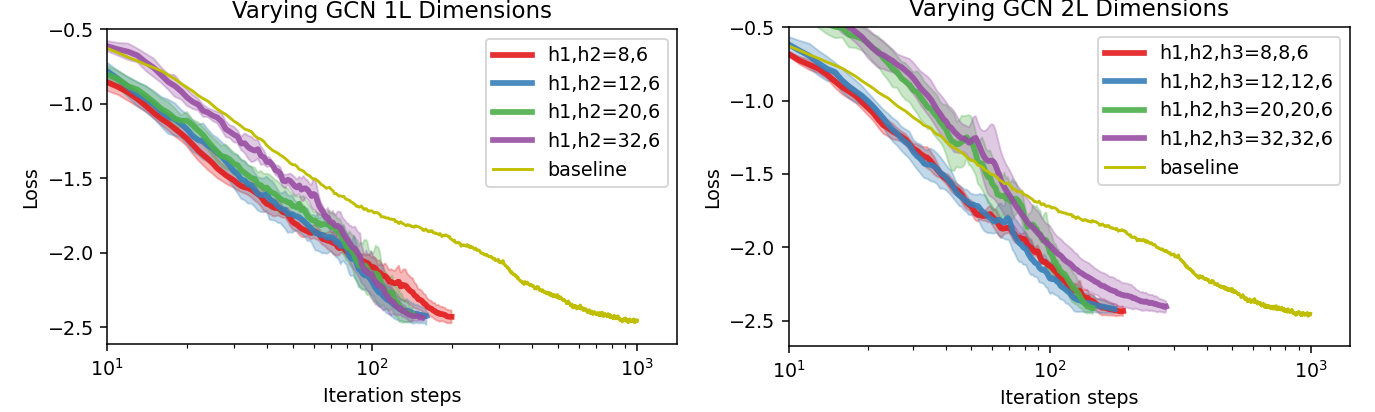

In [456]:
with open('original_adam_results2/200pt_1000eps_bat1_card30_r20_train_result_regular.pickle','rb') as f:
    original_loss,_,original_out = pickle.load(f)
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = .9
l = 3

for (h1,h2,color) in [(8,6,c1),(12,6,c2),(20,6,c3),(32,6,c4)]:
    GCN_1L_loss_list = []
    GCN_2L_loss_list = []
    for k in range(5):
        with open('GCN_1L_results2/GCN_1L_200pt_bat1_card30_r20_H{}{}L5_sp15_cth3_{}_train_result_hybrid.pickle'.format(h1,h2,k),'rb') as f:
            GCN_1L_loss,_,_,switch_point = pickle.load(f)
        
        with open('GCN_2L_results2/GCN_2L_200pt_bat1_card30_r20_H{}{}{}L4_sp15_cth3_{}_train_result_hybrid.pickle'.format(h1,h1,h3,k),'rb') as f:
            GCN_2L_loss,_,_,switch_point = pickle.load(f)

        GCN_1L_loss_list.append(GCN_1L_loss)
        GCN_2L_loss_list.append(GCN_2L_loss)
        
    GCN_1L_loss_p = msp(GCN_1L_loss_list)  
    GCN_2L_loss_p = msp(GCN_2L_loss_list)  
        
    ax[0].plot(GCN_1L_loss_p[1], color = color, label='h1,h2={},{}'.format(h1,h2), linewidth = l,alpha = a)
    ax[1].plot(GCN_2L_loss_p[1], color = color, label='h1,h2,h3={},{},{}'.format(h1,h1,h2), linewidth = l,alpha = a)
    ax[0].fill_between( GCN_1L_loss_p[0], GCN_1L_loss_p[2] ,GCN_1L_loss_p[3], alpha=0.3, color = color)
    ax[1].fill_between( GCN_2L_loss_p[0], GCN_2L_loss_p[2] ,GCN_2L_loss_p[3], alpha=0.3, color = color)

for i in range(2):
    ax[i].plot(np.arange(len(original_loss)),original_loss,'y',label='baseline')
    ax[i].legend(loc=1);

    ax[i].set_xscale('log')
    ax[i].set_xlabel('Iteration steps',fontname='sherif')
    ax[i].set_ylabel('Loss', fontname='sherif')
#     ax[i].set_xticks(fontname='sherif',size=20)
#     ax[i].set_yticks(fontname='sherif',size=20);
    ax[i].set_xlim(10)
    ax[i].set_ylim(top=-0.5)
    ax[i].set_aspect(9/16)

    ax[i].set_title('Varying GCN {}L Dimensions'.format(i+1));


plt.tight_layout();
# forceAspect(plt.gca(),aspect=5)

plt.savefig('200_pc_GCN_vary_dims.pdf')

# Convergence Comparison 

## GCN 1L Time Comparison

<IPython.core.display.Javascript object>


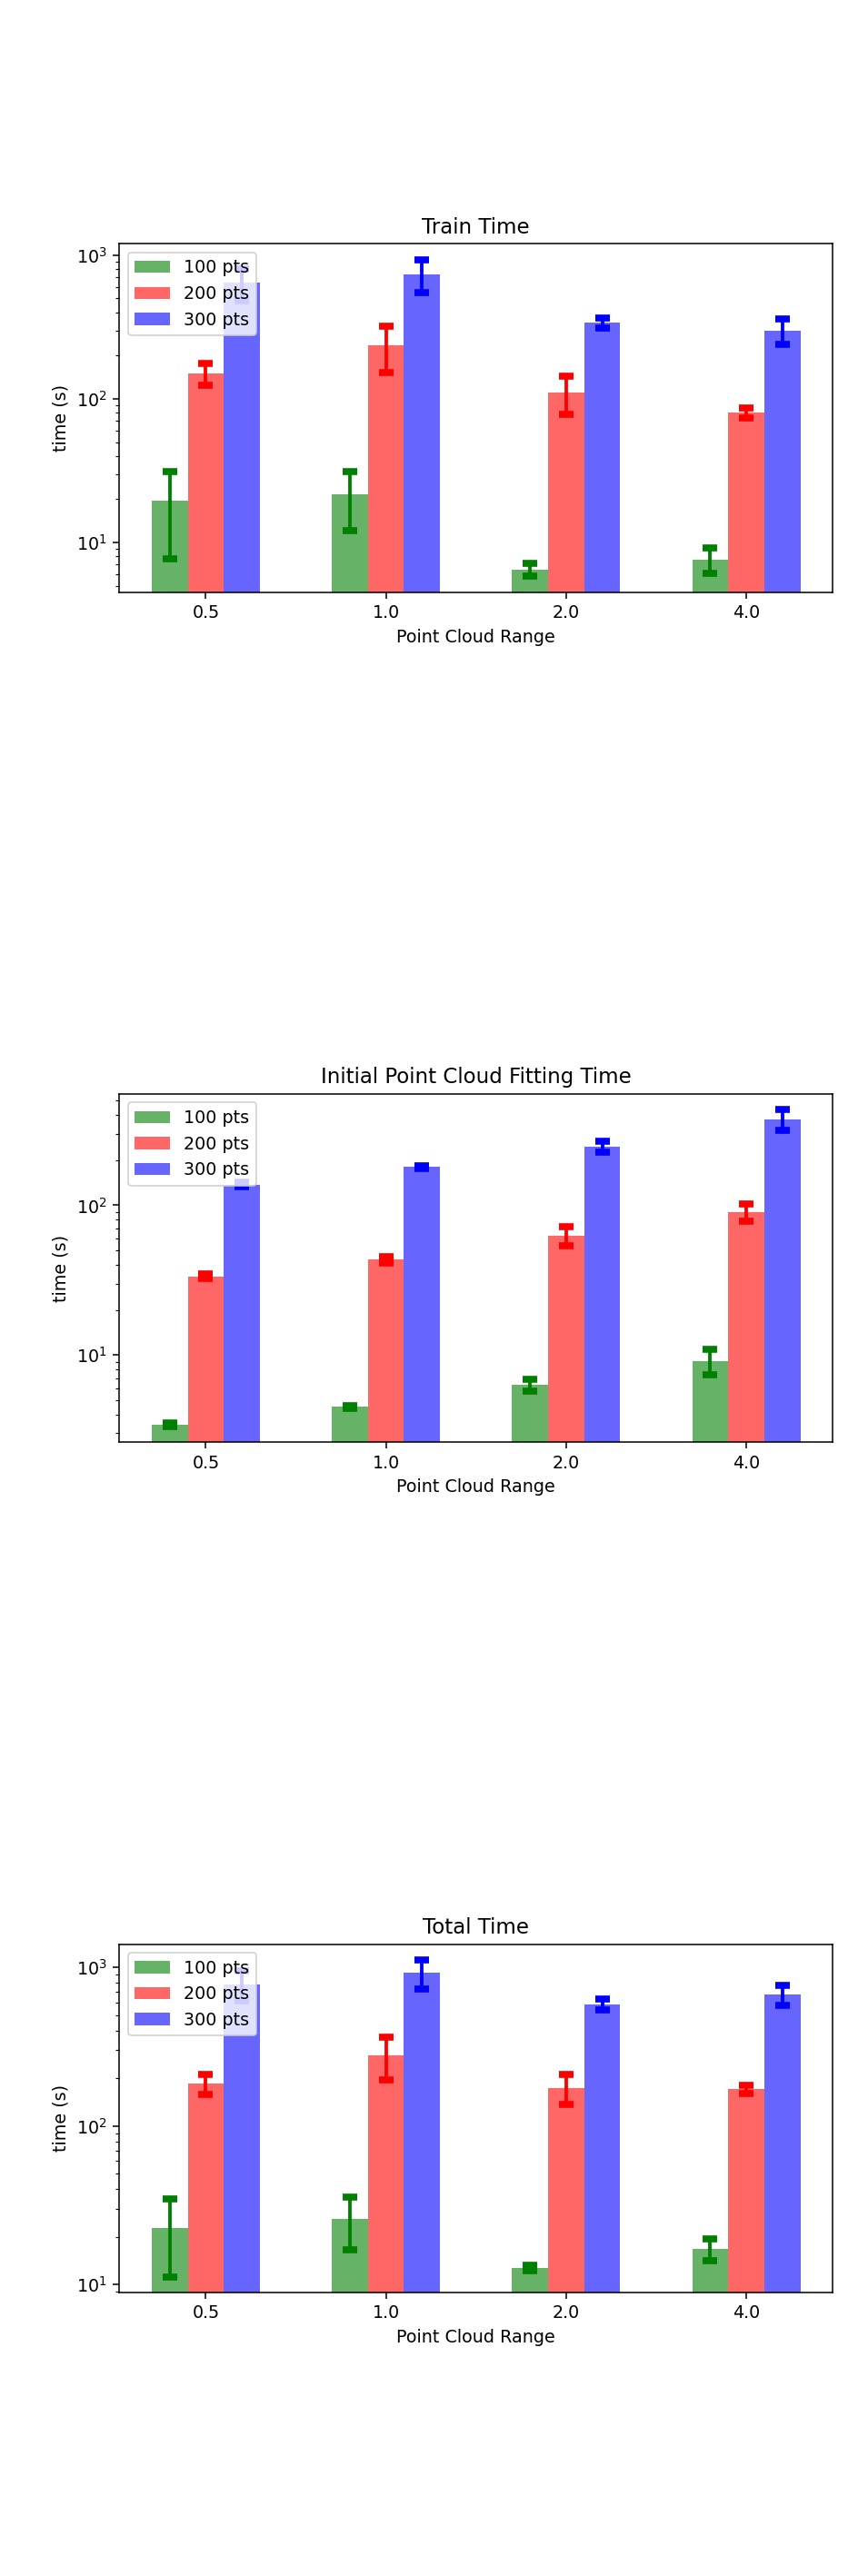

In [198]:
import pickle

fig,ax = plt.subplots(3,1,figsize=(5,15))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2
# plt.xticks(X_axis,X)
# plt.xlabel('Point Cloud Range')


lam = 0.5

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_time_list = []
    std_train_time_list = []
    
    avg_fit_time_list = []
    std_fit_time_list = []
    
    avg_total_time_list = []
    std_total_time_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        fit_time_list = []
        train_time_list = []
        total_time_list = []
        
        for k in range(5):
            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,_ = pickle.load(f)

            fit_time_list.append(prefit_time)
            train_time_list.append(train_time[-1])
            total_time_list.append(prefit_time+train_time[-1])
            
#             fit_time_list.append(prefit_time / N**3)
#             train_time_list.append(train_time[-1] / N**3)
#             total_time_list.append((prefit_time+train_time[-1]) / N**3)
        
        avg_train_time_list.append(np.array(train_time_list).mean())
        std_train_time_list.append(np.array(train_time_list).std())
        
        avg_fit_time_list.append(np.array(fit_time_list).mean())
        std_fit_time_list.append(np.array(fit_time_list).std())
        
        avg_total_time_list.append(np.array(total_time_list).mean())
        std_total_time_list.append(np.array(total_time_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_time_list,yerr=std_train_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train Time')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('time (s)')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].legend(loc=2)
        
    ax[1].bar(X_axis+offset,avg_fit_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_fit_time_list,yerr=std_fit_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Initial Point Cloud Fitting Time')
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('time (s)')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].legend(loc=2)
    
    ax[2].bar(X_axis+offset,avg_total_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[2].errorbar(X_axis+offset,avg_total_time_list,yerr=std_total_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[2].set_title('Total Time') 
    ax[2].set_xlabel('Point Cloud Range')
    ax[2].set_ylabel('time (s)')
    ax[2].set_xticks(X_axis)
    ax[2].set_xticklabels(X)
    ax[2].legend(loc=2)

plt.ylabel('time (s)')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
plt.tight_layout()
for i in range(3):
    forceAspect(ax[i],aspect=8/9)
# plt.suptitle('GCN 1L Time Comparison Log')
# plt.savefig('GCN 1L Time Comparison Log.pdf')

## GCN 1L Epoch Comparison 

<IPython.core.display.Javascript object>


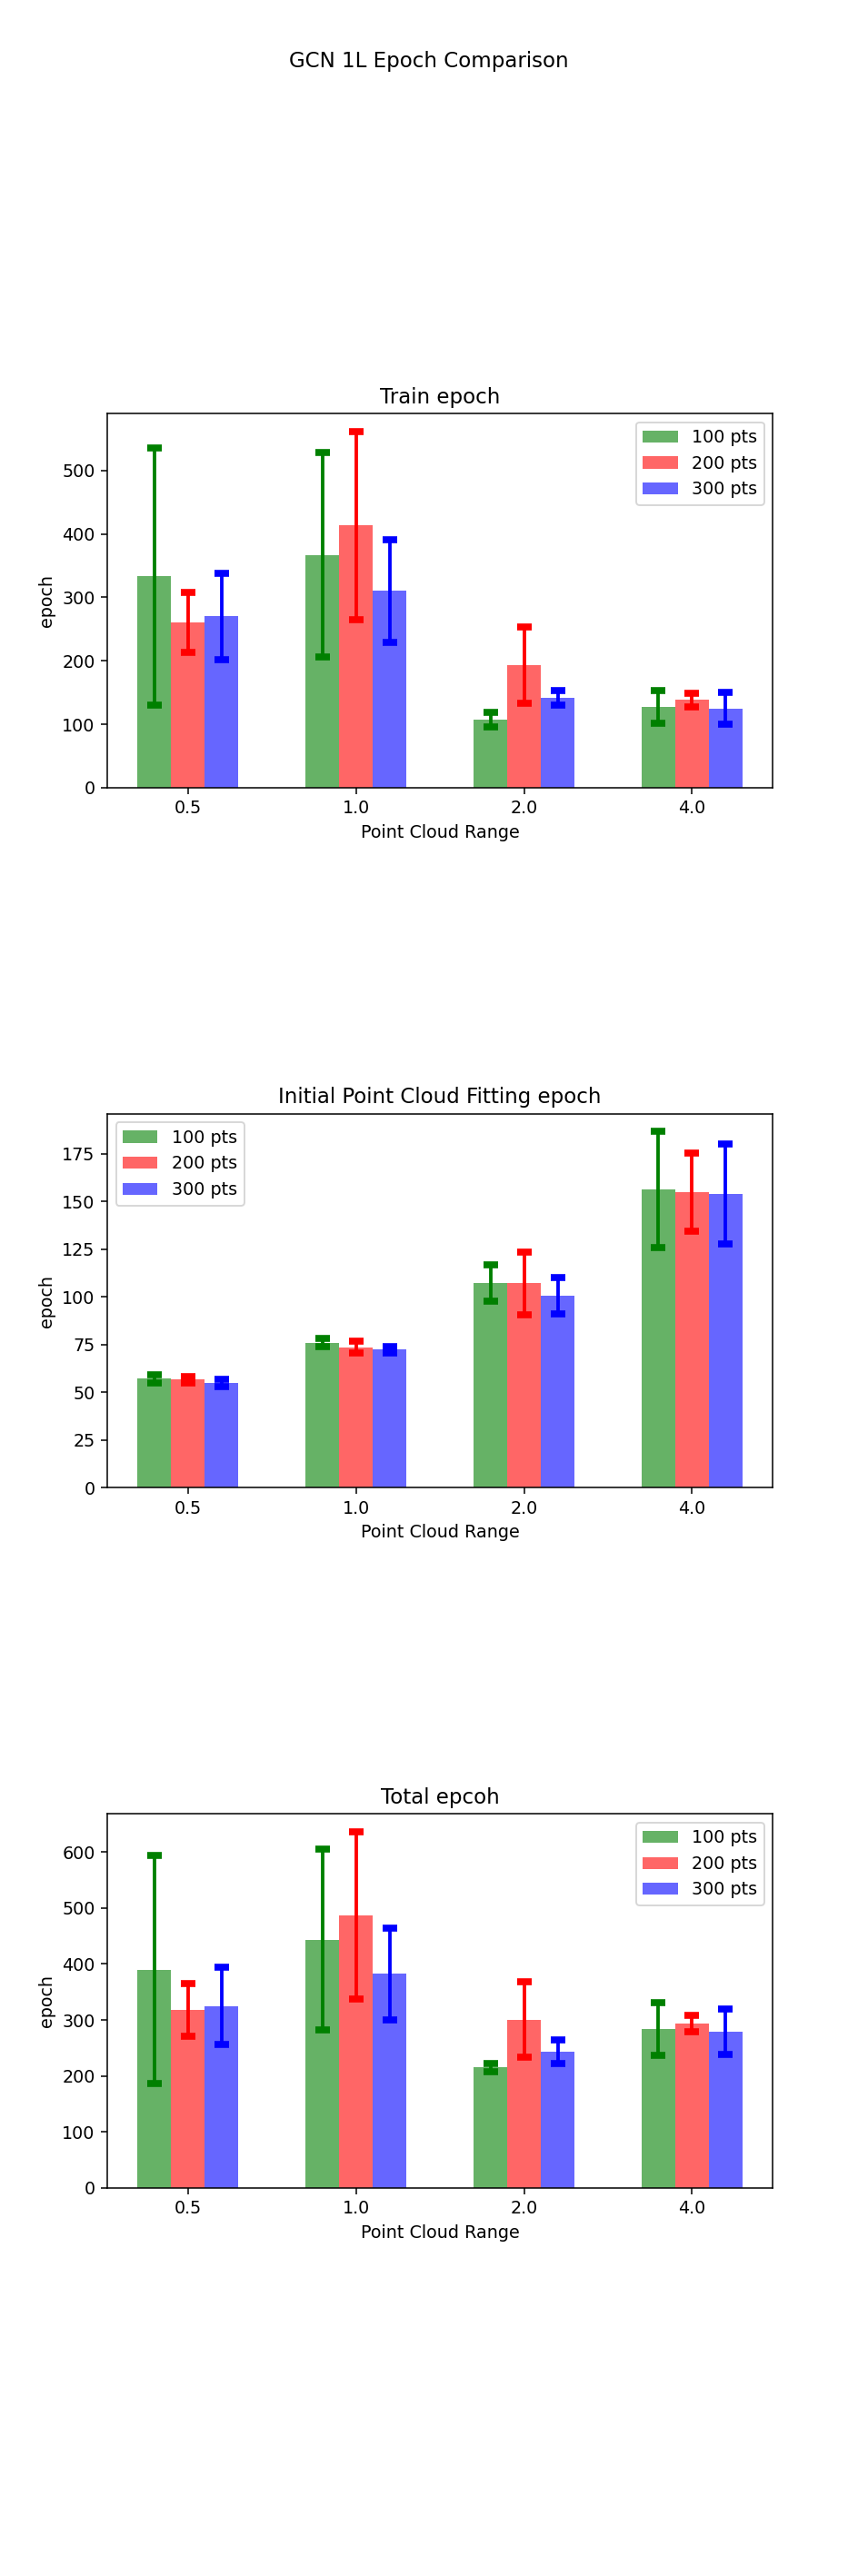

Text(0.5, 0.98, 'GCN 1L Epoch Comparison')

In [168]:
import pickle

fig,ax = plt.subplots(3,1,figsize=(5,15))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_epoch_list = []
    std_train_epoch_list = []
    
    avg_fit_epoch_list = []
    std_fit_epoch_list = []
    
    avg_total_epoch_list = []
    std_total_epoch_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        fit_epoch_list = []
        train_epoch_list = []
        total_epoch_list = []
        
        for k in range(5):
            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,_ = pickle.load(f)

            fit_epoch_list.append(len(prefit_loss))
            train_epoch_list.append(len(train_loss))
            total_epoch_list.append(len(prefit_loss)+len(train_loss))
        
        avg_train_epoch_list.append(np.array(train_epoch_list).mean())
        std_train_epoch_list.append(np.array(train_epoch_list).std())
        
        avg_fit_epoch_list.append(np.array(fit_epoch_list).mean())
        std_fit_epoch_list.append(np.array(fit_epoch_list).std())
        
        avg_total_epoch_list.append(np.array(total_epoch_list).mean())
        std_total_epoch_list.append(np.array(total_epoch_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_epoch_list,yerr=std_train_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train epoch')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('epoch')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].legend()
        
    ax[1].bar(X_axis+offset,avg_fit_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_fit_epoch_list,yerr=std_fit_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Initial Point Cloud Fitting epoch')
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('epoch')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].legend()
    
    ax[2].bar(X_axis+offset,avg_total_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[2].errorbar(X_axis+offset,avg_total_epoch_list,yerr=std_total_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[2].set_title('Total epcoh') 
    ax[2].set_xlabel('Point Cloud Range')
    ax[2].set_ylabel('epoch')
    ax[2].set_xticks(X_axis)
    ax[2].set_xticklabels(X)
    ax[2].legend()

for i in range(3):
    forceAspect(ax[i],aspect=16/9)
# plt.tight_layout()
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
plt.suptitle('GCN 1L Epoch Comparison')
# plt.savefig('GCN 1L Epoch Comparison.png')

## GCN 2L Time Comparison

<IPython.core.display.Javascript object>


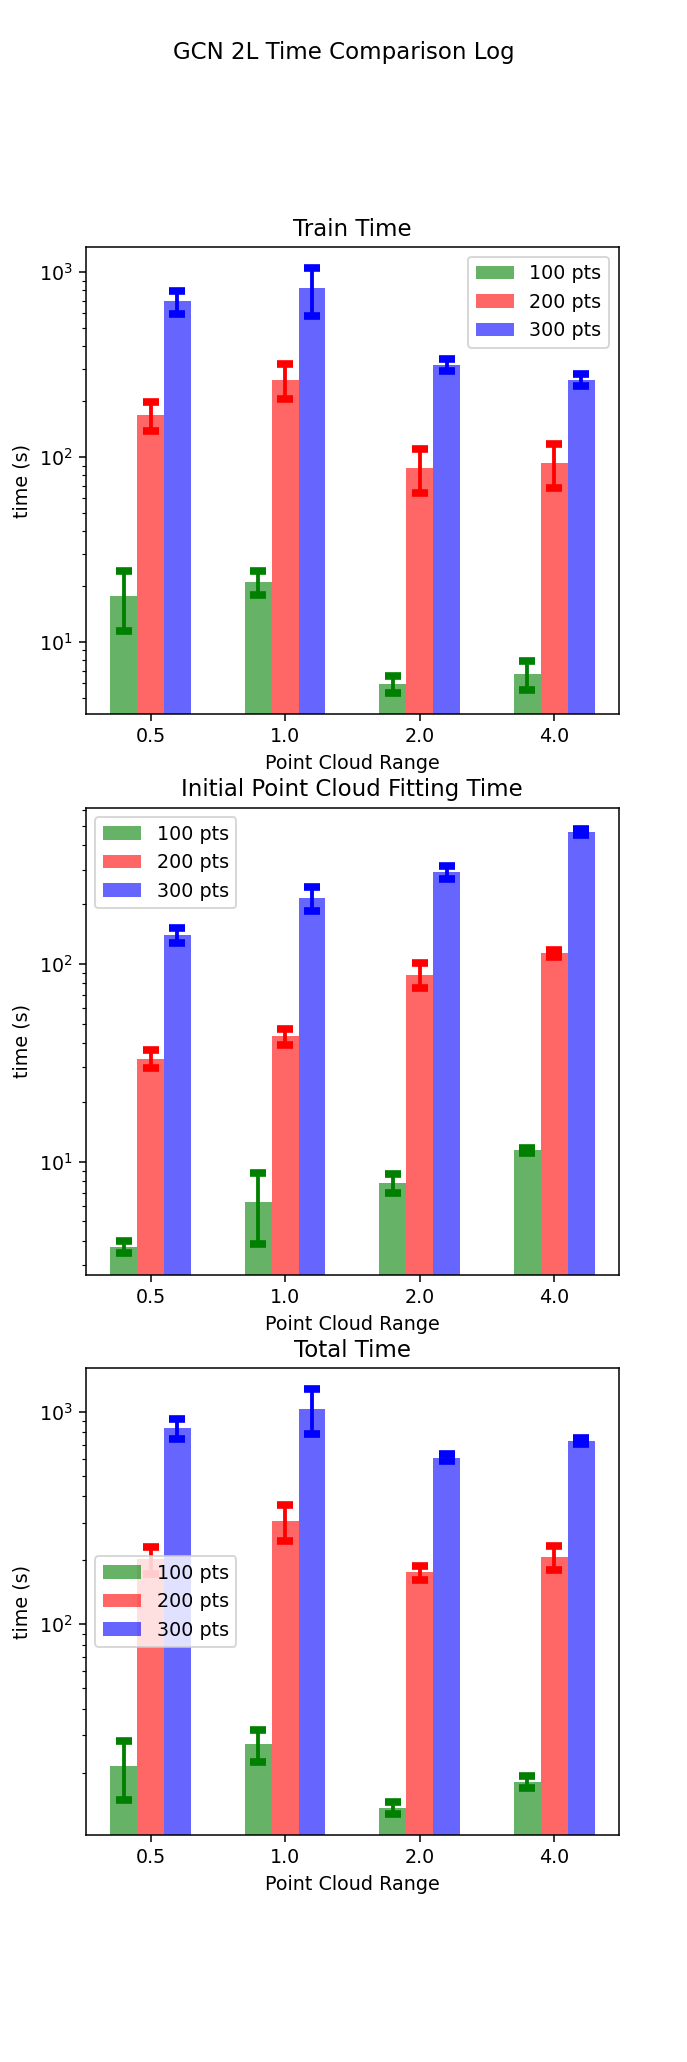

In [105]:
import pickle

fig,ax = plt.subplots(3,1,figsize=(5,15))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2
# plt.xticks(X_axis,X)
# plt.xlabel('Point Cloud Range')


lam = 0.5

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_time_list = []
    std_train_time_list = []
    
    avg_fit_time_list = []
    std_fit_time_list = []
    
    avg_total_time_list = []
    std_total_time_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        fit_time_list = []
        train_time_list = []
        total_time_list = []
        
        for k in range(5):
            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,_ = pickle.load(f)

            fit_time_list.append(prefit_time)
            train_time_list.append(train_time[-1])
            total_time_list.append(prefit_time+train_time[-1])
            
#             fit_time_list.append(prefit_time / N**3)
#             train_time_list.append(train_time[-1] / N**3)
#             total_time_list.append((prefit_time+train_time[-1]) / N**3)
        
        avg_train_time_list.append(np.array(train_time_list).mean())
        std_train_time_list.append(np.array(train_time_list).std())
        
        avg_fit_time_list.append(np.array(fit_time_list).mean())
        std_fit_time_list.append(np.array(fit_time_list).std())
        
        avg_total_time_list.append(np.array(total_time_list).mean())
        std_total_time_list.append(np.array(total_time_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_time_list,yerr=std_train_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train Time')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('time (s)')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].legend()
        
    ax[1].bar(X_axis+offset,avg_fit_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_fit_time_list,yerr=std_fit_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Initial Point Cloud Fitting Time')
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('time (s)')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].legend()
    
    ax[2].bar(X_axis+offset,avg_total_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[2].errorbar(X_axis+offset,avg_total_time_list,yerr=std_total_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[2].set_title('Total Time') 
    ax[2].set_xlabel('Point Cloud Range')
    ax[2].set_ylabel('time (s)')
    ax[2].set_xticks(X_axis)
    ax[2].set_xticklabels(X)
    ax[2].legend()

plt.ylabel('time (s)')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
plt.suptitle('GCN 2L Time Comparison Log')
plt.savefig('GCN 2L Time Comparison Log.pdf')

## GCN 2L Epoch Comparison

In [95]:
import pickle

fig,ax = plt.subplots(3,1,figsize=(5,15))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2
# plt.xticks(X_axis,X)
# plt.xlabel('Point Cloud Range')


lam = 0.5

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_epoch_list = []
    std_train_epoch_list = []
    
    avg_fit_epoch_list = []
    std_fit_epoch_list = []
    
    avg_total_epoch_list = []
    std_total_epoch_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        fit_epoch_list = []
        train_epoch_list = []
        total_epoch_list = []
        
        for k in range(5):
            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,_ = pickle.load(f)

            fit_epoch_list.append(len(prefit_loss))
            train_epoch_list.append(len(train_loss))
            total_epoch_list.append(len(prefit_loss)+len(train_loss))
        
        
        avg_train_epoch_list.append(np.array(train_epoch_list).mean())
        std_train_epoch_list.append(np.array(train_epoch_list).std())
        
        avg_fit_epoch_list.append(np.array(fit_epoch_list).mean())
        std_fit_epoch_list.append(np.array(fit_epoch_list).std())
        
        avg_total_epoch_list.append(np.array(total_epoch_list).mean())
        std_total_epoch_list.append(np.array(total_epoch_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_epoch_list,yerr=std_train_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train epoch')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('epoch')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].legend()
        
    ax[1].bar(X_axis+offset,avg_fit_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_fit_epoch_list,yerr=std_fit_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Initial Point Cloud Fitting epoch')
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('epoch')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].legend()
    
    ax[2].bar(X_axis+offset,avg_total_epoch_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[2].errorbar(X_axis+offset,avg_total_epoch_list,yerr=std_total_epoch_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[2].set_title('Total epcoh') 
    ax[2].set_xlabel('Point Cloud Range')
    ax[2].set_ylabel('epoch')
    ax[2].set_xticks(X_axis)
    ax[2].set_xticklabels(X)
    ax[2].legend()


# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
plt.suptitle('GCN 2L Epoch Comparison')
# plt.savefig('Time Comparison 2.png')

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'GCN 2L Epoch Comparison')

# Speed Up Measurement

In [63]:
def get_conv_epoch(loss):
    assert len(loss) >= 1000
    loss_mean = np.array(loss[-100:]).mean()
    loss_sig = np.sqrt(np.array(loss[-100:]).var())
    conv_val = loss_mean + 2*loss_sig

    for i,loss in enumerate(loss):
        if loss <= conv_val:
#             print('converges at epoch ',i)
            return i,loss_mean,loss_sig,conv_val 

<IPython.core.display.Javascript object>


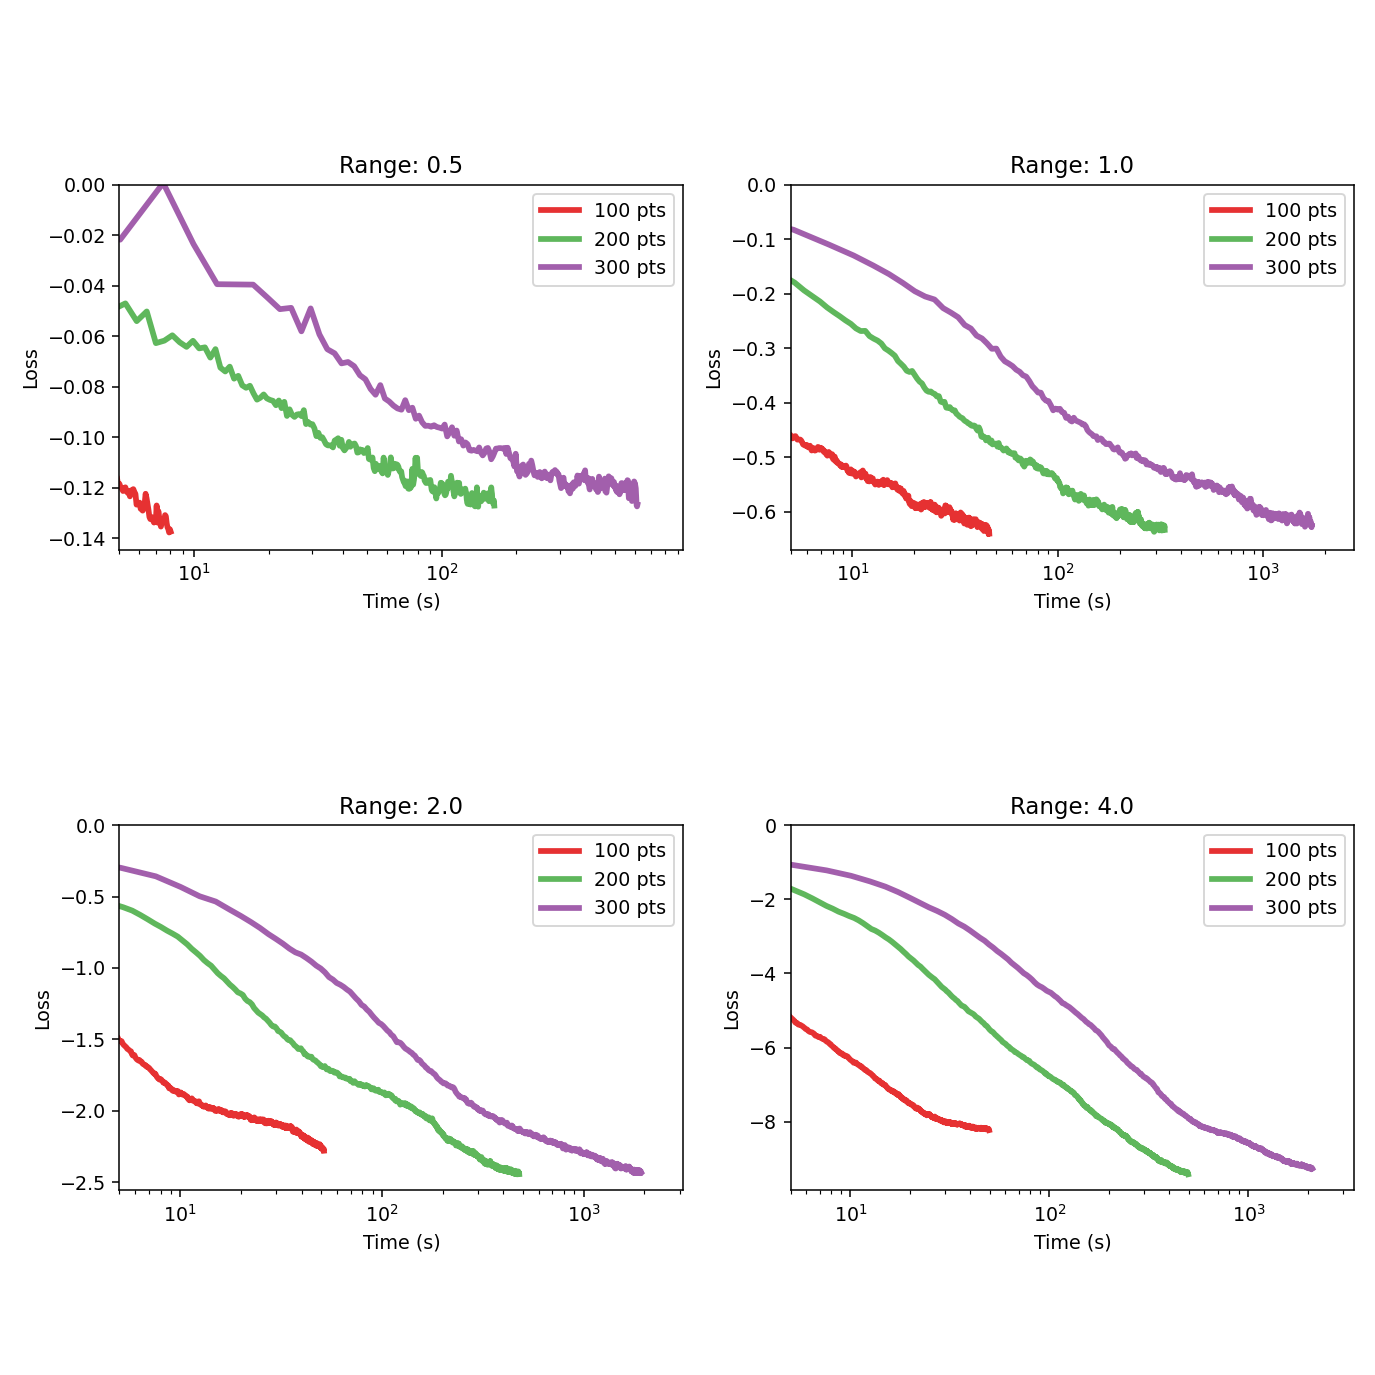

N=100,r=0.5: conv_epoch=139,loss_mean=-0.144,loss_sig=0.003,conv_val=-0.138
N=200,r=0.5: conv_epoch=284,loss_mean=-0.138,loss_sig=0.003,conv_val=-0.131
N=300,r=0.5: conv_epoch=258,loss_mean=-0.136,loss_sig=0.004,conv_val=-0.128
ax[i].get_xlim(): (5.0, 944.1868572093143)
scale_str: log
asp: 10.187614103891674
N=100,r=1.0: conv_epoch=794,loss_mean=-0.651,loss_sig=0.005,conv_val=-0.642
N=200,r=1.0: conv_epoch=581,loss_mean=-0.649,loss_sig=0.005,conv_val=-0.638
N=300,r=1.0: conv_epoch=722,loss_mean=-0.638,loss_sig=0.005,conv_val=-0.629
ax[i].get_xlim(): (5.0, 2777.4787085866924)
scale_str: log
asp: 2.6547777706264686
N=100,r=2.0: conv_epoch=892,loss_mean=-2.322,loss_sig=0.020,conv_val=-2.282
N=200,r=2.0: conv_epoch=855,loss_mean=-2.456,loss_sig=0.006,conv_val=-2.445
N=300,r=2.0: conv_epoch=806,loss_mean=-2.466,loss_sig=0.014,conv_val=-2.438
ax[i].get_xlim(): (5.0, 3122.9717503748234)
scale_str: log
asp: 0.7085958093885805
N=100,r=4.0: conv_epoch=859,loss_mean=-8.282,loss_sig=0.023,conv_val

In [361]:
def forceAspect(ax,aspect):
    #aspect is width/height
    scale_str = ax.get_xaxis().get_scale()
    print('scale_str:',scale_str)
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
#     print('xmax:'.format(xmax))
#     print('xmin:'.format(xmin))
#     print('ymax:'.format(ymax))
#     print('ymin:'.format(ymin))
    if scale_str=='linear':
        asp = abs((xmax-xmin)/(ymax-ymin))/aspect
    elif scale_str=='log':
#         asp = abs((np.log(xmax)-np.log(xmin))/(np.log(ymax)-np.log(ymin)))/aspect
#         asp = abs((xmax-xmin)/(scipy.log(ymax)-scipy.log(ymin)))/aspect
#         asp = abs((np.log(ymax)-np.log(ymin))/(np.log(xmax)-np.log(xmin)))/aspect
        asp = abs((np.log(xmax)-np.log(xmin))/(ymax-ymin))/aspect

    print('asp:',asp)
    ax.set_aspect(asp)

fig,axes = plt.subplots(2,2,figsize = (10, 10))
a = .9
l = 3

ax = [axes[i][j] for i in range(2) for j in range(2)]

for i,r in enumerate([0.5,1.0,2.0,4.0]):
    for N,card,color in [(100,15,c1),(200,30,c3),(300,50,c4)]:
    
        with open('original_adam_results2/{}pt_1000eps_bat1_card{}_r{}_train_result_regular.pickle'.format(N,card,int(r*10)),'rb') as f:
            loss_list,runtime_list,_ = pickle.load(f)
        
        conv_epoch,loss_mean,loss_sig,conv_val = get_conv_epoch(loss_list)
        print('N={},r={}: conv_epoch={},loss_mean={:.3f},loss_sig={:.3f},conv_val={:.3f}'.format(N,r,conv_epoch,loss_mean,loss_sig,conv_val))
    
        ax[i].plot(runtime_list[:conv_epoch],loss_list[:conv_epoch],color=color,label='{} pts'.format(N), linewidth=l, alpha=a)
#         ax[i].plot(runtime_list,loss_list,color=color,label='{} pts'.format(N), linewidth=l, alpha=a)
    ax[i].legend()
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Loss')
    ax[i].set_xscale('log')
    ax[i].set_title('Range: {}'.format(r))
    ax[i].set_xlim(5)
    ax[i].set_ylim(top=0)
    print('ax[i].get_xlim():',ax[i].get_xlim())
    forceAspect(ax[i],aspect=32/9)

# plt.suptitle('Linear Model Convergence')
plt.tight_layout()
plt.savefig('Linear_Model_Convergence.pdf')
# plt.xscale('log')
# plt.xlim(10)

## GCN 1L Speed Up

<IPython.core.display.Javascript object>


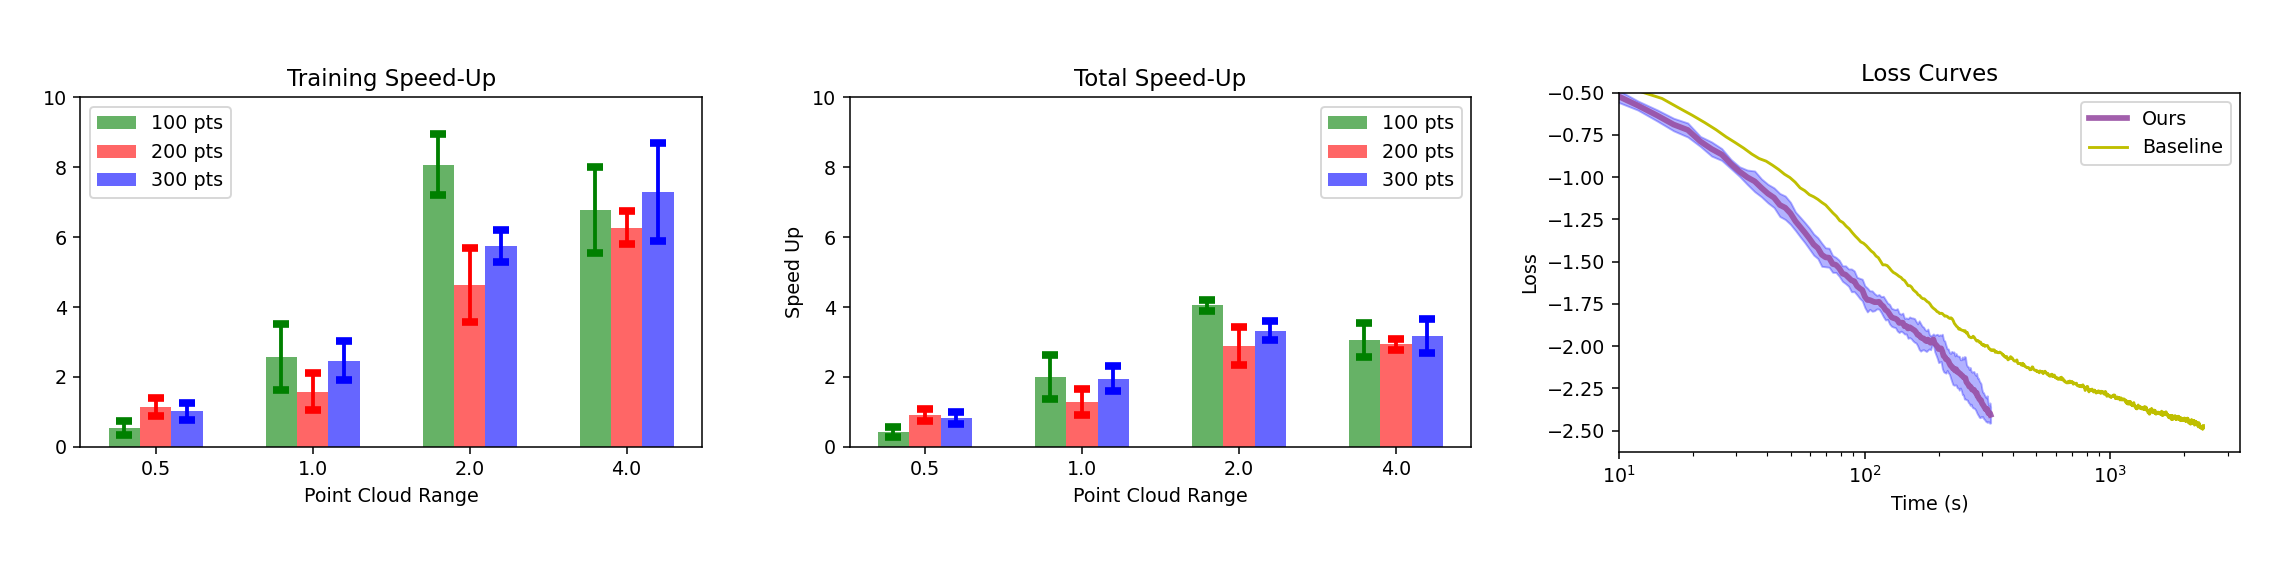

scale_str: linear
asp: 0.44550000000000006
scale_str: linear
asp: 0.44550000000000006


In [364]:
import pickle

fig,ax = plt.subplots(1,3,figsize=(12,3))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_speedup_list = []
    std_train_speedup_list = []
    
    avg_total_speedup_list = []
    std_total_speedup_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        train_speedup_list = []
        total_speedup_list = []
        
        for k in range(5):
            with open('original_adam_results2/{}pt_1000eps_bat1_card{}_r{}_train_result_regular.pickle'.format(N,card,int(r*10)),'rb') as f:
                original_loss,original_time,_ = pickle.load(f)
            
            conv_epoch,_,_,_ = get_conv_epoch(original_loss)
            conv_time = original_time[conv_epoch]
            
            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,switch_point = pickle.load(f)
#             print('N={},r={}: switch epoch {}'.format(N,r,switch_point))

            train_speedup_list.append(conv_time / train_time[-1])
            total_speedup_list.append(conv_time / (prefit_time+train_time[-1]))
            
#             train_speedup_list.append(conv_time / (train_time[-1]*N**3))
#             total_speedup_list.append(conv_time / ((prefit_time+train_time[-1])*N**3))
        
        avg_train_speedup_list.append(np.array(train_speedup_list).mean())
        std_train_speedup_list.append(np.array(train_speedup_list).std())
        
        avg_total_speedup_list.append(np.array(total_speedup_list).mean())
        std_total_speedup_list.append(np.array(total_speedup_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_speedup_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_speedup_list,yerr=std_train_speedup_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Training Speed-Up')
    ax[0].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('Speed Up')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].set_ylim([0,10])
    ax[0].legend()
    
    ax[1].bar(X_axis+offset,avg_total_speedup_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_total_speedup_list,yerr=std_total_speedup_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Total Speed-Up') 
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('Speed Up')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].set_ylim([0,10])
    ax[1].legend()

    
with open('original_adam_results2/300pt_1000eps_bat1_card50_r20_train_result_regular.pickle','rb') as f:
    original_loss,original_time,original_out = pickle.load(f)
a = .9
l = 3

for (h1,h2) in [(8,6)]:
    loss_list = []
    time_list = []
    for k in range(5):
        with open('GCN_1L_results2/GCN_1L_300pt_bat2_card50_r20_H{}{}L5_sp15_cth3_mse30_{}_prefit_result.pickle'.format(h1,h2,k),'rb') as f:
            _,_,GCN_1L_prefit_time = pickle.load(f)
            
        with open('GCN_1L_results2/GCN_1L_300pt_bat2_card50_r20_H{}{}L5_sp15_cth3_mse30_{}_train_result_hybrid.pickle'.format(h1,h2,k),'rb') as f:
            GCN_1L_loss,GCN_1L_time,_,switch_point = pickle.load(f)

        loss_list.append(GCN_1L_loss)
        time_list.append(GCN_1L_time)
    p1 = msp(loss_list) # 3 list of loss
    t1 = msp(time_list)
    ax[2].plot(t1[1],p1[1], color = c4, linewidth = l,alpha = a, label='Ours')
    ax[2].fill_between( t1[1], p1[2] ,p1[3], alpha=0.3, color = color)

# plt.axvline(x=100, color='black', linestyle='dotted', linewidth = l, alpha = a) # model switching
ax[2].plot(original_time,original_loss,'y',label='Baseline')
ax[2].legend(loc=1);

ax[2].set_xscale('log')

ax[2].set_xlabel('Time (s)',fontname='sherif')
ax[2].set_ylabel('Loss', fontname='sherif')
# ax[2].set_xticks()
# ax[2].set_yticks();

ax[2].set_title('Loss Curves', fontname='sherif');

ax[2].set_xlim(10)
ax[2].set_ylim(top=-0.5)
ax[2].set_aspect(11/16)


# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
for i in range(2):
    forceAspect(ax[i],aspect=16/9)
#     ax[i].set_aspect(9/16)
plt.tight_layout()
# plt.suptitle('GCN 1L Time Speed Up')
plt.savefig('GCN_1L_Time_SpeedUp.pdf')

## GCN 1L Runtime

In [474]:
import pickle
import matplotlib
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"
      self.style='sci'

fig,ax = plt.subplots(1,3,figsize=(15,3))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_time_list = []
    std_train_time_list = []
    
    avg_fit_time_list = []
    std_fit_time_list = []
    
    avg_total_time_list = []
    std_total_time_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        fit_time_list = []
        train_time_list = []
        total_time_list = []
        
        for k in range(5):
            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,_ = pickle.load(f)

#             fit_time_list.append(prefit_time)
#             train_time_list.append(train_time[-1])
#             total_time_list.append(prefit_time+train_time[-1])
            
            fit_time_list.append(prefit_time / N**3.5)
            train_time_list.append(train_time[-1] / N**3.5)
            total_time_list.append((prefit_time+train_time[-1]) / N**3.5)
        
        avg_train_time_list.append(np.array(train_time_list).mean())
        std_train_time_list.append(np.array(train_time_list).std())
        
        avg_fit_time_list.append(np.array(fit_time_list).mean())
        std_fit_time_list.append(np.array(fit_time_list).std())
        
        avg_total_time_list.append(np.array(total_time_list).mean())
        std_total_time_list.append(np.array(total_time_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_time_list,yerr=std_train_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train Time')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('Time (s)')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
#     ax[0].legend(loc=2,prop={"size":10})
        
    ax[1].bar(X_axis+offset,avg_fit_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_fit_time_list,yerr=std_fit_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Initial Point Cloud Fitting Time')
    ax[1].set_xlabel('Point Cloud Range')
#     ax[1].set_ylabel('Time (s)')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].legend(loc=2,prop={"size":10})
    
    ax[2].bar(X_axis+offset,avg_total_time_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[2].errorbar(X_axis+offset,avg_total_time_list,yerr=std_total_time_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[2].set_title('Total Time') 
    ax[2].set_xlabel('Point Cloud Range')
#     ax[2].set_ylabel('Time (s)')
    ax[2].set_xticks(X_axis)
    ax[2].set_xticklabels(X)
#     ax[2].legend(loc=2,prop={"size":10})


plt.tight_layout()
ax[0].set_aspect(40/9)
ax[1].set_aspect(45/9)
ax[2].set_aspect(50/9)
for i in range(3):
#     ax[i].set_ylim(top=4e-5,bottom=0)
#     forceAspect(ax[i],aspect=16/9)
#     ax[i].set_aspect(16/9)

#     ax[i].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_yscale('log')

# plt.ticklabel_format(axis='y',style='')
# plt.suptitle('GCN 1L Time Comparison Log')
plt.savefig('GCN_1L_Time_Comparison_Normalized.pdf')

<IPython.core.display.Javascript object>

## Point Cloud Visualization

<IPython.core.display.Javascript object>


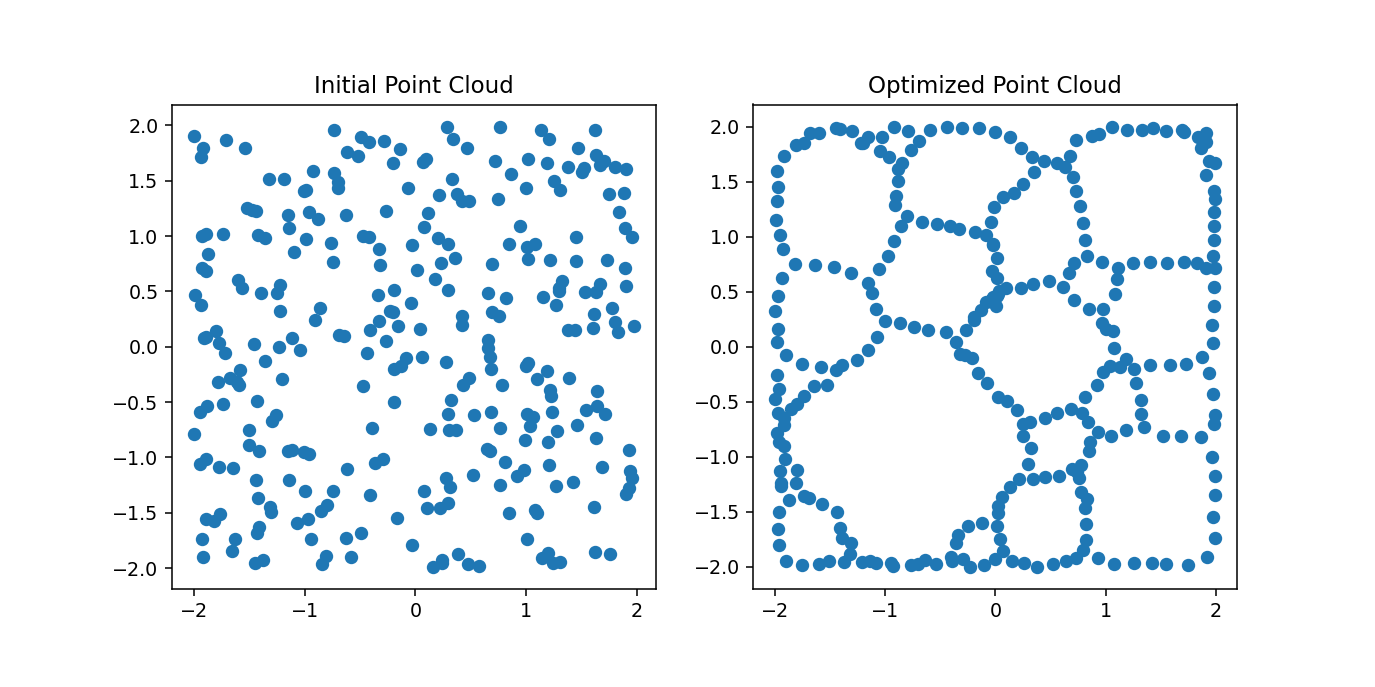

scale_str: linear
asp: 0.9994908482772825
scale_str: linear
asp: 0.9997026298056361


In [363]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

np.random.seed(1)
Xinit = np.array(np.random.uniform(high=2., low=-2., size=(300,2)), dtype=np.float32)
ax[0].scatter(Xinit[:,0],Xinit[:,1])
ax[0].set_title('Initial Point Cloud')

with open('GCN_1L_results2/GCN_1L_300pt_bat2_card50_r20_H{}{}L5_sp15_cth3_mse30_{}_train_result_hybrid.pickle'.format(8,6,4),'rb') as f:
    _,_,GCN_1L_out,_ = pickle.load(f)

ax[1].scatter(GCN_1L_out[-1][:,0],GCN_1L_out[-1][:,1])
ax[1].set_title('Optimized Point Cloud')

for i in range(2):
    forceAspect(ax[i],aspect=1)
plt.savefig('Point_Cloud_Visualization.pdf')

## Speed-Up vs Loss

<IPython.core.display.Javascript object>


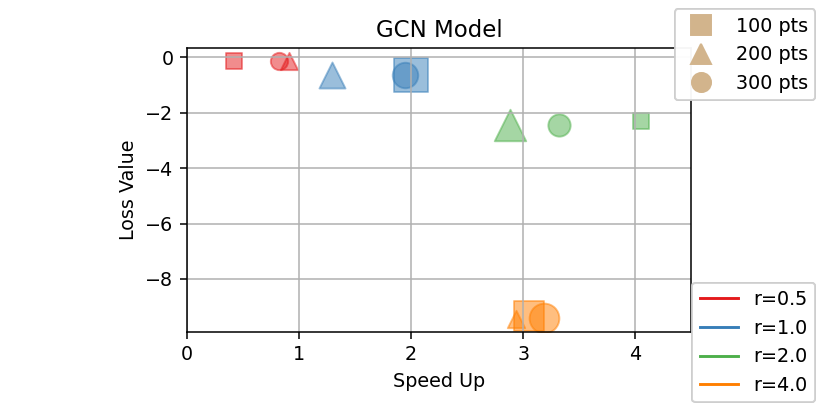

scale_str: linear
asp: 0.2469776563016867


In [476]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

marker_dict = {'100':'s','200':'^','300':'o'}
color_dict = {'0.5':c1,'1.0':c2,'2.0':c3,'4.0':c5}

fig = plt.figure(figsize=(6,3))

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    
    for r in [0.5,1.0,2.0,4.0]:
        train_speedup_list = []
        total_speedup_list = []
        loss_list = []
        
        with open('original_adam_results2/{}pt_1000eps_bat1_card{}_r{}_train_result_regular.pickle'.format(N,card,int(r*10)),'rb') as f:
            original_loss,original_time,_ = pickle.load(f)
        
        for k in range(5):
            conv_epoch,_,_,_ = get_conv_epoch(original_loss)
            conv_time = original_time[conv_epoch]
            
            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_1L_results2/GCN_1L_{}pt_bat2_card{}_r{}_H86L5_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,switch_point = pickle.load(f)

            train_speedup_list.append(conv_time / train_time[-1])
            total_speedup_list.append(conv_time / (prefit_time+train_time[-1]))
            loss_list.append(train_loss[-1])
        
        mean_train_speedup = np.array(train_speedup_list).mean()
        std_train_speedup = np.array(train_speedup_list).std()
        
        mean_total_speedup = np.array(total_speedup_list).mean()
        std_total_speedup = np.array(total_speedup_list).std()
        
        mean_loss = np.array(loss_list).mean()
        
        plt.scatter(mean_total_speedup,mean_loss,marker=marker_dict[str(N)],color=color_dict[str(r)],s=std_total_speedup*500,alpha=0.5)

square = mlines.Line2D([], [], color='tan', marker='s', linestyle='None',
                          markersize=10, label='100 pts')
triangle = mlines.Line2D([], [], color='tan', marker='^', linestyle='None',
                          markersize=10, label='200 pts')
circle = mlines.Line2D([], [], color='tan', marker='o', linestyle='None',
                          markersize=10, label='300 pts')        
legend1 = fig.legend(handles=[square, triangle, circle],loc=1,prop={"size":10})

r5 = mlines.Line2D([], [], color=color_dict['0.5'], linestyle='-',
                          markersize=10, label='r=0.5')
r10 = mlines.Line2D([], [], color=color_dict['1.0'], linestyle='-',
                          markersize=10, label='r=1.0')
r20 = mlines.Line2D([], [], color=color_dict['2.0'], linestyle='-',
                          markersize=10, label='r=2.0')   
r40 = mlines.Line2D([], [], color=color_dict['4.0'], linestyle='-',
                          markersize=10, label='r=4.0')   
legend2 = fig.legend(handles=[r5,r10,r20,r40],loc=4,prop={"size":10})

fig.add_artist(legend1)
fig.add_artist(legend2)
plt.xlim(0,4.5)
plt.xlabel('Speed Up')
plt.ylabel('Loss Value')
plt.title('GCN Model')
plt.grid()
plt.tight_layout()
forceAspect(plt.gca(),16/9)
plt.show()
plt.savefig('GCN_1L_Loss_vs_Speedup.pdf')
  

## GCN 2L Speed Up

<IPython.core.display.Javascript object>


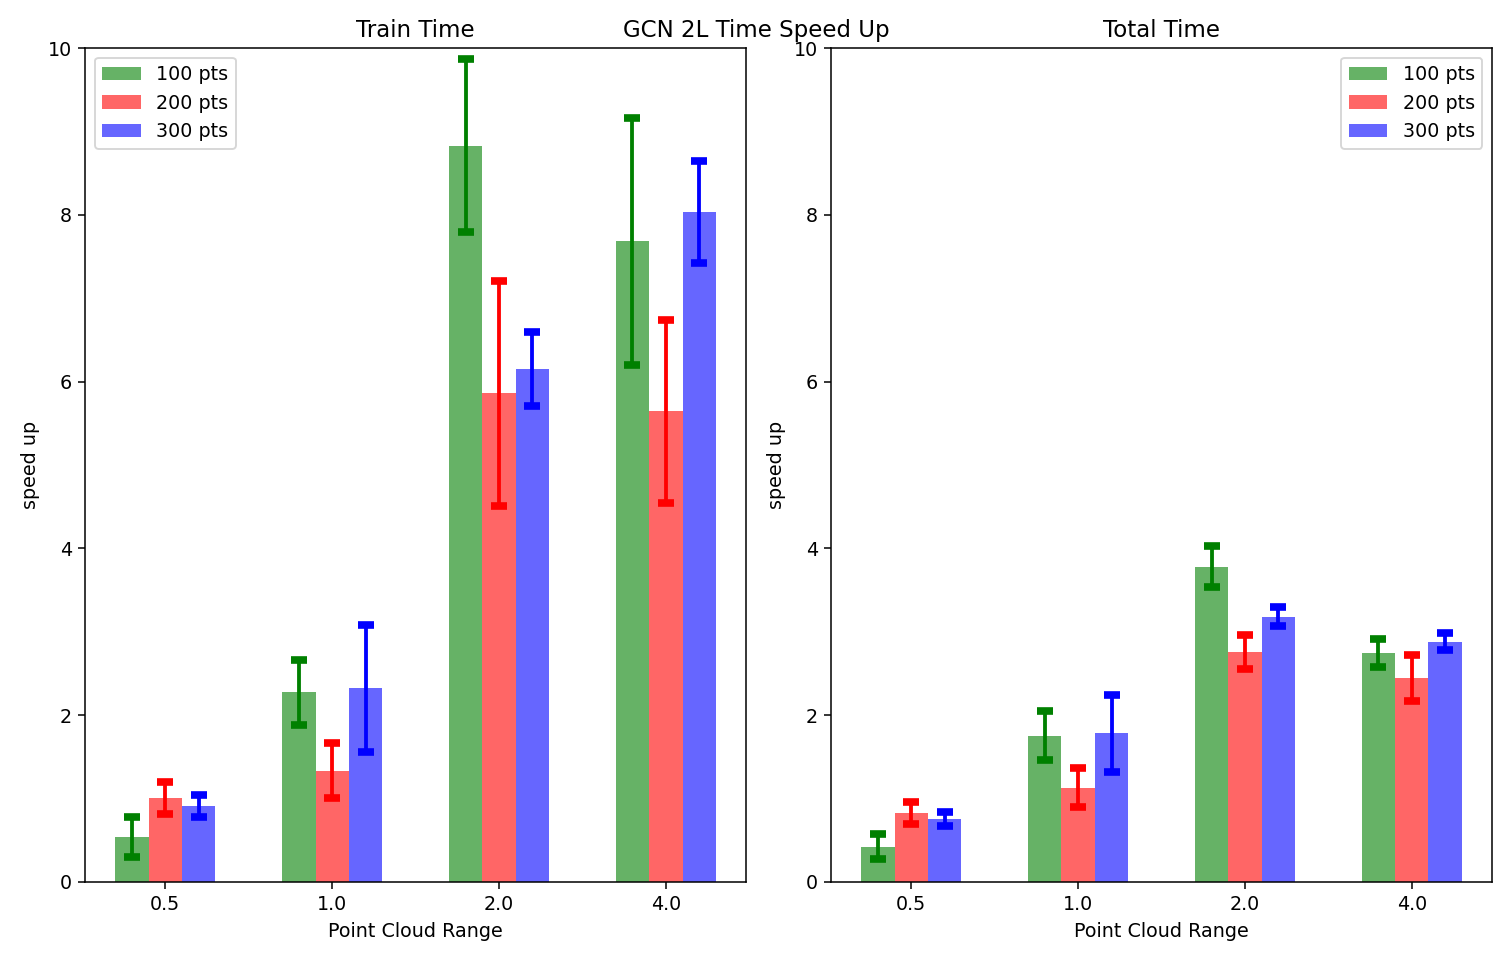

In [84]:
import pickle

fig,ax = plt.subplots(1,2,figsize=(11,7))
X = ['0.5','1.0','2.0','4.0']
X_axis = np.arange(4)*2
# plt.xticks(X_axis,X)
# plt.xlabel('Point Cloud Range')

for N,card,mse in [(100,15,0.01),(200,30,0.02),(300,50,0.03)]:
    avg_train_speedup_list = []
    std_train_speedup_list = []
    
    avg_total_speedup_list = []
    std_total_speedup_list = []
    
    for r in [0.5,1.0,2.0,4.0]:
        train_speedup_list = []
        total_speedup_list = []
        
        for k in range(5):
            with open('original_adam_results2/{}pt_1000eps_bat1_card{}_r{}_train_result_regular.pickle'.format(N,card,int(r*10)),'rb') as f:
                original_loss,original_time,_ = pickle.load(f)
            
            conv_epoch,_,_,_ = get_conv_epoch(original_loss)
            conv_time = original_time[conv_epoch]
            
            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_prefit_result.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                prefit_loss,_,prefit_time = pickle.load(f)

            with open('GCN_2L_results2/GCN_2L_{}pt_bat2_card{}_r{}_H886L4_sp15_cth3_mse{}_{}_train_result_hybrid.pickle'.format(N,card,int(r*10),int(mse*1000),k),'rb') as f:
                train_loss,train_time,_,switch_point = pickle.load(f)
#             print('N={},r={}: switch epoch {}'.format(N,r,switch_point))

            train_speedup_list.append(conv_time / train_time[-1])
            total_speedup_list.append(conv_time / (prefit_time+train_time[-1]))
            
#             train_speedup_list.append(conv_time / (train_time[-1]*N**3))
#             total_speedup_list.append(conv_time / ((prefit_time+train_time[-1])*N**3))
        
        avg_train_speedup_list.append(np.array(train_speedup_list).mean())
        std_train_speedup_list.append(np.array(train_speedup_list).std())
        
        avg_total_speedup_list.append(np.array(total_speedup_list).mean())
        std_total_speedup_list.append(np.array(total_speedup_list).std())
        
    offset, color = 0, 'r'
    if N == 100: offset,color = -0.4,'g'
    elif N == 300: offset,color = 0.4,'b'
    
    ax[0].bar(X_axis+offset,avg_train_speedup_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[0].errorbar(X_axis+offset,avg_train_speedup_list,yerr=std_train_speedup_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[0].set_title('Train Time')
    ax[0].set_xlabel('Point Cloud Range')
    ax[0].set_ylabel('speed up')
    ax[0].set_xticks(X_axis)
    ax[0].set_xticklabels(X)
    ax[0].set_ylim([0,10])
    ax[0].legend()
    
    ax[1].bar(X_axis+offset,avg_total_speedup_list,0.4,color=color,alpha=0.6,label='{} pts'.format(N))
    ax[1].errorbar(X_axis+offset,avg_total_speedup_list,yerr=std_total_speedup_list,color=color,lw=2,capsize=4,capthick=4,linestyle='')
    ax[1].set_title('Total Time') 
    ax[1].set_xlabel('Point Cloud Range')
    ax[1].set_ylabel('speed up')
    ax[1].set_xticks(X_axis)
    ax[1].set_xticklabels(X)
    ax[1].set_ylim([0,10])
    ax[1].legend()

# plt.ylabel('speed up')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
plt.tight_layout()
plt.suptitle('GCN 2L Time Speed Up')
plt.savefig('GCN 2L Time Speed Up.pdf')